# RAG From Scratch: Query Transformations

Welcome to this comprehensive tutorial on RAG (Retrieval-Augmented Generation) query transformations! 

## What Are Query Transformations?

Think of query transformations as different ways to ask the same question to get better answers. Imagine you're looking for information in a library, but instead of asking just one question, you ask several related questions from different angles. This increases your chances of finding the most relevant books.

In RAG systems, we face a similar challenge. Sometimes a single user question doesn't retrieve the best documents from our knowledge base. Query transformations help us overcome this limitation by:

- **Rephrasing questions** to capture different perspectives
- **Breaking down complex questions** into simpler parts
- **Generating multiple variations** to cast a wider retrieval net
- **Creating more abstract versions** of specific questions

## Why Do We Need This?

Traditional RAG has a fundamental problem: it relies on semantic similarity between your question and the documents. But what if your question uses different words than the documents? What if your question is too specific or too broad? Query transformations solve these issues by giving us multiple "shots" at finding the right information.

In this tutorial, we'll explore five powerful query transformation techniques:
1. **Multi Query** - Generate multiple versions of the same question
2. **RAG-Fusion** - Combine results from multiple queries using smart ranking
3. **Decomposition** - Break complex questions into simpler sub-questions
4. **Step Back** - Ask broader, more general versions of specific questions
5. **HyDE** - Generate hypothetical answers to improve retrieval

## Environment Setup

Let's start by installing the necessary packages. Think of this as gathering all the tools we'll need for our RAG experiments.

In [ ]:
# Install all the packages we need for our RAG experiments
# These include LangChain (our RAG framework), OpenAI (our LLM), and ChromaDB (our vector database)
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

## Configuration Setup

Now we need to configure our environment with API keys. LangSmith helps us track and debug our RAG chains, while OpenAI provides our language model.

**Important**: In a real project, never hardcode your API keys like this. Use environment variables or secure key management instead!

LangSmith documentation: https://docs.smith.langchain.com/

In [ ]:
import os

# Enable LangSmith tracing to monitor our RAG chains
# This helps us see what's happening inside our query transformations
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '<your-api-key-here>'

# OpenAI API key for our language model
os.environ['OPENAI_API_KEY'] = '<your-api-key-here>'

## Part 5: Multi Query - Asking the Same Question Different Ways

### The Problem with Single Queries

Imagine you're asking a librarian "What are approaches to task decomposition?" But the books in the library use phrases like "methods for breaking down tasks" or "strategies for task division." Your exact question might miss these relevant books because the words don't match perfectly.

### The Multi Query Solution

Multi Query solves this by generating several versions of your question, each using different words and phrasing. It's like asking the same question in multiple ways:
- "What are approaches to task decomposition?"
- "How can complex tasks be broken down?"
- "What methods exist for dividing large tasks?"

Then we search with all these variations and combine the results, removing duplicates.

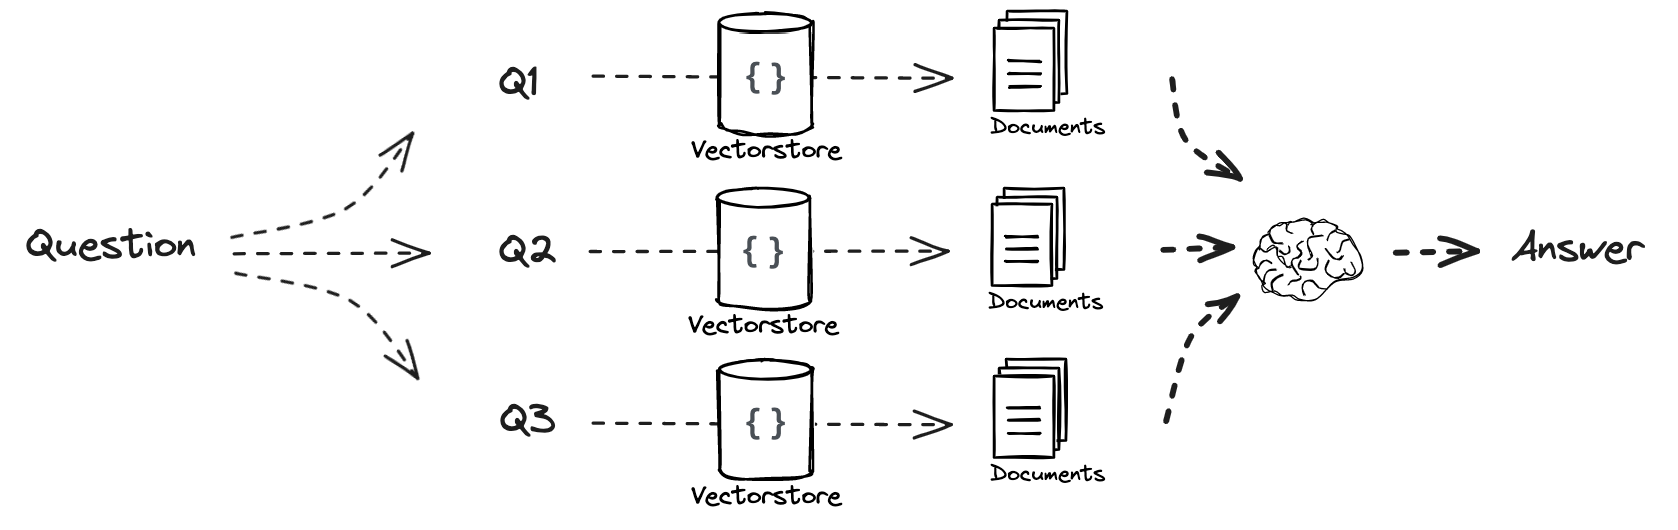

### Setting Up Our Knowledge Base

First, let's create a vector database with some content to search through. We'll use a blog post about AI agents as our knowledge source.

In [ ]:
# Build a sample vector database for our experiments
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load a blog post about AI agents - this will be our knowledge base
# This particular post covers task decomposition, planning, and tool use in AI agents
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split the content into smaller chunks
# Why 500 characters? It's large enough to contain meaningful information
# but small enough to be specific and retrievable
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# Create embeddings and store in a vector database
# Embeddings turn text into numbers that capture semantic meaning
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

### Using Multi Query Retriever - The Simple Way

LangChain provides a built-in `MultiQueryRetriever` that handles the complexity for us. Here's how it works behind the scenes:

1. Takes your original question
2. Uses an LLM to generate multiple variations of the question
3. Searches the vector database with each variation
4. Combines and deduplicates the results
5. Returns the unique documents found

This is perfect when you want quick results without customization.

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

# Our test question - we'll see how Multi Query improves retrieval for this
question = "What are the approaches to Task Decomposition?"

# Create our language model with temperature=0 for consistent results
# Temperature controls randomness: 0 = deterministic, 1 = very creative
llm = ChatOpenAI(temperature=0)

# Create the Multi Query Retriever
# This will automatically generate query variations and handle the retrieval
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), # Our vector database retriever
    llm=llm  # The language model to generate query variations
)

In [ ]:
# Enable logging so we can see what query variations are generated
# This is helpful for understanding how the Multi Query works
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

# Run the Multi Query Retriever
# Watch the logs to see what alternative questions it generates!
unique_docs = retriever_from_llm.invoke(question)
print(f"Retrieved {len(unique_docs)} unique documents")

# The power of Multi Query: instead of getting results from just one query,
# we get results from multiple query variations, giving us better coverage

### Customizing Multi Query - Building Your Own Prompt

Sometimes you want more control over how query variations are generated. Maybe you want exactly 5 variations, or you want them focused on specific aspects. Let's build a custom Multi Query system.

**Key Components:**
1. **Custom Prompt**: Tells the LLM exactly how to generate variations
2. **Output Parser**: Converts the LLM's response into a list of questions
3. **Chain**: Connects prompt → LLM → parser

In [ ]:
from typing import List
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

# Create a custom parser to split the LLM's response into individual questions
# The LLM will return questions separated by newlines, and we need to parse them
class LineListOutputParser(BaseOutputParser[List[str]]):
    """Converts LLM output into a clean list of questions."""

    def parse(self, text: str) -> List[str]:
        # Split by newlines and remove any empty lines
        lines = text.strip().split("\n")
        return list(filter(None, lines))  # Remove empty lines

# Create our custom parser instance
output_parser = LineListOutputParser()

# Define a custom prompt for query generation
# This prompt is more specific than the default - it asks for exactly 5 variations
# and explains the goal of overcoming distance-based similarity limitations
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

# Use the same LLM configuration
llm = ChatOpenAI(temperature=0)

# Create a chain: prompt → LLM → parser
# This chain will take a question and return a list of alternative questions
llm_chain = QUERY_PROMPT | llm | output_parser

# Set up our test question
question = "What are the approaches to Task Decomposition?"

In [ ]:
# Create a Multi Query Retriever with our custom chain
retriever = MultiQueryRetriever(
    retriever=vectordb.as_retriever(),  # Our vector database
    llm_chain=llm_chain,  # Our custom query generation chain
    parser_key="lines"  # Tell it to use the "lines" attribute of parsed output
)

# Test with a different question to see how it performs
# Note: The original question was about task decomposition, but this asks about regression
# This demonstrates that our Multi Query system can handle any type of question
unique_docs = retriever.invoke("What does the course say about regression?")
print(f"Retrieved {len(unique_docs)} unique documents")

# Even though this document might not have much about regression,
# Multi Query will try different phrasings to find any related content

## Part 6: RAG-Fusion - Smart Ranking with Multiple Queries

### Beyond Multi Query: The Need for Better Ranking

Multi Query is great, but it has a limitation. When we combine results from different query variations, we just merge them together. But what if a document appears in the results of multiple query variations? That's probably a really good document!

### Enter RAG-Fusion

RAG-Fusion takes Multi Query to the next level by using **Reciprocal Rank Fusion (RRF)**. Think of it this way:
- If a document ranks #1 in one search and #3 in another, it's probably very relevant
- If a document only appears in one search at rank #10, it's probably less relevant
- RRF gives higher scores to documents that consistently appear across multiple searches

### The RAG-Fusion Process
1. **Generate multiple query variations** (like Multi Query)
2. **Search with each variation** separately
3. **Apply Reciprocal Rank Fusion** to combine and re-rank results
4. **Use the top-ranked documents** for final answer generation

### Key References:
- [LangChain RAG-Fusion Cookbook](https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev)
- [Original Blog Post: "Forget RAG, the Future is RAG-Fusion"](https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)

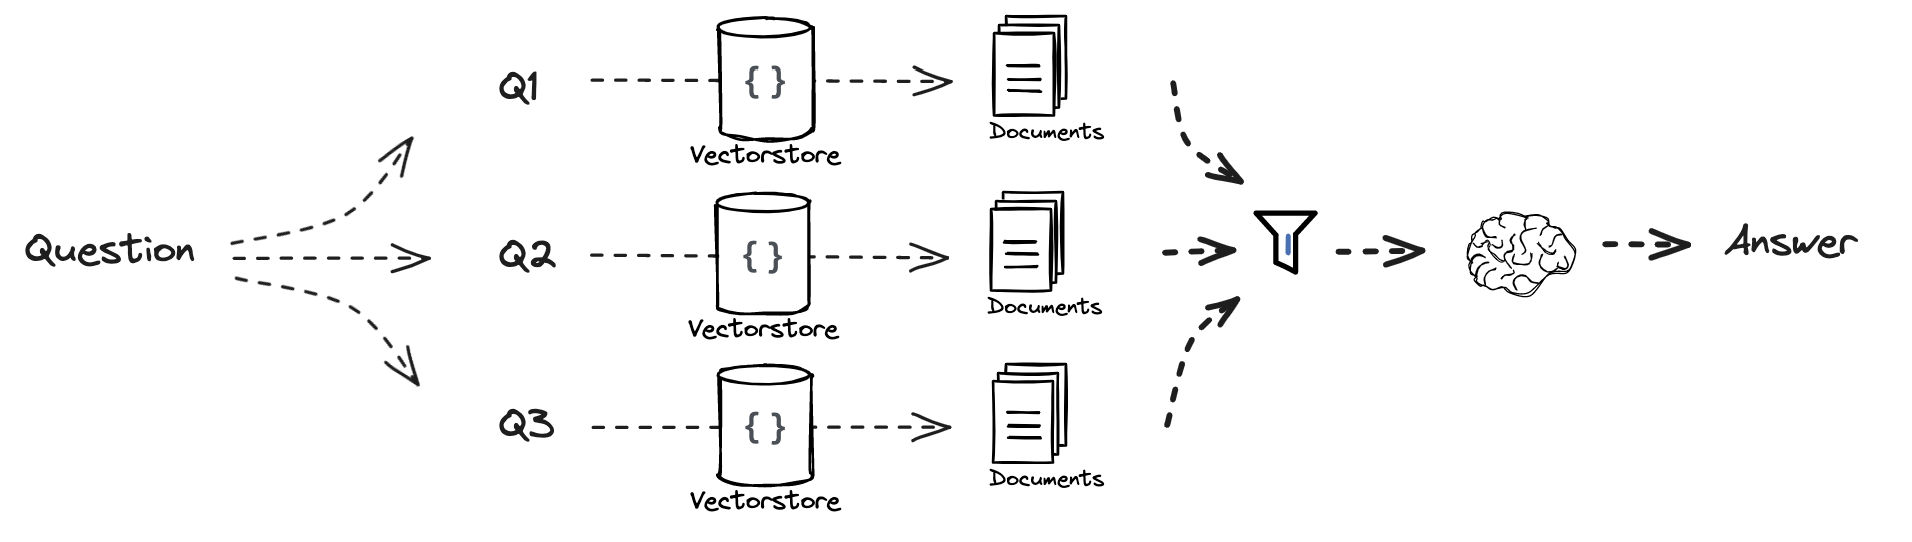

### Understanding RAG-Fusion with LangChain

RAG-Fusion represents a significant advancement in Retrieval-Augmented Generation. Here's what makes it special:

**The Innovation**: Instead of treating all retrieved documents equally, RAG-Fusion recognizes that documents appearing in multiple search results are likely more relevant.

**How RRF Works**: The Reciprocal Rank Fusion algorithm assigns scores based on ranking positions. A document ranked #1 gets a higher score than one ranked #5. If a document appears in multiple rankings, its scores are added together.

**Real-World Analogy**: Imagine you're asking three librarians the same question. If all three recommend the same book, but from different sections, that book is probably your best bet.

**Benefits of RAG-Fusion**:
- **Better relevance**: Documents that consistently appear get higher priority
- **Diverse perspectives**: Multiple query variations capture different angles
- **Robust retrieval**: Less likely to miss important information
- **Quality filtering**: Poor matches from single queries get filtered out

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Create a prompt specifically for RAG-Fusion query generation
# Notice this asks for 4 queries instead of 5, and focuses on "related" queries
# This is slightly different from Multi Query - we want variations that are related but distinct
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Create the query generation chain for RAG-Fusion
# This chain: takes a question → generates multiple queries → splits them into a list
generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)  # Generate the query variations
    | StrOutputParser()  # Convert to string
    | (lambda x: x.split("\n"))  # Split into individual queries
)

# This simple chain will take our original question and return 4 related queries

In [ ]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ 
    Reciprocal Rank Fusion: Combines multiple ranked lists into a single ranking.
    
    How it works:
    - For each document at rank 'r' in a list, it gets score 1/(r + k)
    - If a document appears in multiple lists, scores are added together
    - Higher total score = more relevant document
    
    Parameters:
    - results: List of lists, each containing ranked documents
    - k: Smoothing parameter (default 60). Higher k = less emphasis on rank differences
    
    Example:
    - Document at rank 1: score = 1/(1+60) = 0.016
    - Document at rank 5: score = 1/(5+60) = 0.015
    - If same document appears at rank 1 and rank 5: total score = 0.031
    """
    
    # Dictionary to store combined scores for each unique document
    fused_scores = {}

    # Process each ranked list of documents
    for docs in results:
        # Go through each document and its position (rank) in this list
        for rank, doc in enumerate(docs):
            # Convert document to string to use as unique identifier
            # This allows us to detect when the same document appears in multiple lists
            doc_str = dumps(doc)
            
            # Initialize score for new documents
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            
            # Add RRF score: 1 / (rank + k)
            # Lower rank (higher position) = higher score
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort documents by their fused scores (highest first)
    # Return list of (document, score) tuples
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results

# Create the complete RAG-Fusion retrieval chain
# This chain: question → multiple queries → parallel retrieval → RRF ranking
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion

# Test it with our question
docs = retrieval_chain_rag_fusion.invoke({"question": question})
print(f"RAG-Fusion retrieved and ranked {len(docs)} documents")

# The result is a list of (document, score) tuples, ranked by relevance

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

# Now let's create the complete RAG-Fusion system with answer generation
# This template is for the final answer generation using the fused documents
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# Create the final RAG-Fusion chain
# This combines retrieval with answer generation
final_rag_chain = (
    {
        # Use our RAG-Fusion retrieval chain to get the best documents
        "context": retrieval_chain_rag_fusion, 
        # Pass through the original question
        "question": itemgetter("question")
    } 
    | prompt  # Format the prompt with context and question
    | llm     # Generate the answer
    | StrOutputParser()  # Convert to clean string
)

# Generate the final answer using RAG-Fusion
answer = final_rag_chain.invoke({"question": question})
print("RAG-Fusion Answer:")
print(answer)

# This answer should be more comprehensive than single-query RAG because:
# 1. We searched with multiple query variations
# 2. We used RRF to prioritize consistently relevant documents
# 3. The LLM has access to the most relevant information

## Part 7: Decomposition - Breaking Complex Questions Into Simple Pieces

### The Challenge of Complex Questions

Sometimes users ask complex questions that try to cover multiple topics at once. For example: "What are the main components of an LLM-powered autonomous agent system?" This question actually contains several sub-questions:
- What are LLM-powered agents?
- What makes an agent autonomous?
- What are the key system components?

### Why Decomposition Works

Think of decomposition like solving a complex math problem. Instead of trying to solve it all at once, you break it down into smaller, manageable steps. Each step is easier to solve, and when you combine the answers, you get a comprehensive solution.

**Benefits of Question Decomposition**:
- **Better retrieval**: Simple questions often match documents better than complex ones
- **More thorough coverage**: Each sub-question can retrieve different relevant documents
- **Easier to answer**: LLMs perform better on focused, specific questions
- **Structured reasoning**: The decomposition process itself helps organize the answer

### Two Approaches to Decomposition

We'll explore two different strategies:
1. **Recursive Answering**: Answer sub-questions in sequence, using previous answers to inform later ones
2. **Independent Answering**: Answer each sub-question separately, then synthesize all answers together

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Create a prompt for breaking down complex questions
# The key instruction: "break down the input into a set of sub-problems / sub-questions
# that can be answers in isolation"
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Set up our language model
llm = ChatOpenAI(temperature=0)

# Create the decomposition chain: question → sub-questions
generate_queries_decomposition = (
    prompt_decomposition 
    | llm 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))  # Split into individual sub-questions
)

# Test with a complex question about LLM agents
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question": question})

print("Original complex question:")
print(question)
print("\nDecomposed sub-questions:")
for i, q in enumerate(questions, 1):
    print(f"{i}. {q}")

In [ ]:
# Display the sub-questions we generated
questions

### Approach 1: Recursive Answering - Building Knowledge Step by Step

In recursive answering, we answer sub-questions one by one, and each answer becomes part of the context for the next question. This is like having a conversation where each response builds on previous ones.

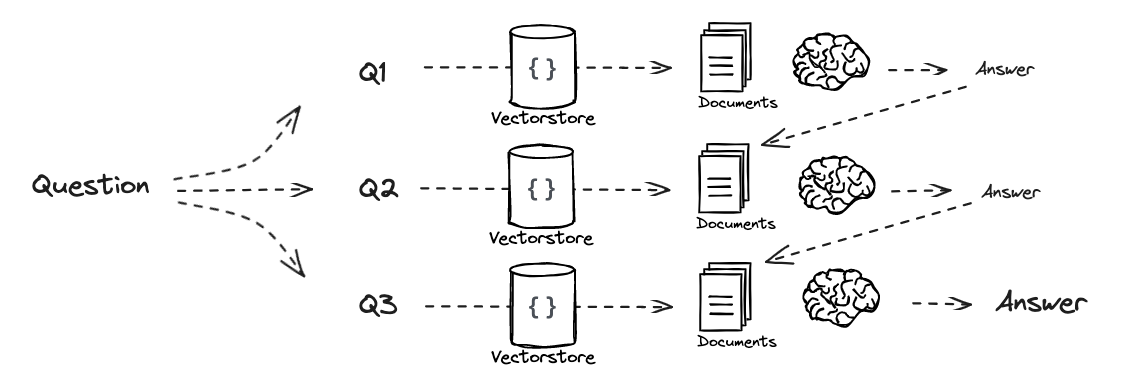

**How it works**:
1. Answer the first sub-question using retrieved documents
2. For the second sub-question, use both retrieved documents AND the first answer as context
3. For the third sub-question, use retrieved documents AND both previous answers
4. This creates a cumulative knowledge base

**When to use recursive answering**:
- When sub-questions build on each other logically
- When later questions need context from earlier answers
- When you want a more conversational, building approach

**Research References**:
- [Least-to-Most Prompting Paper](https://arxiv.org/pdf/2205.10625.pdf)
- [Self-Ask Paper](https://arxiv.org/abs/2212.10509.pdf)

In [ ]:
# Create a prompt template for recursive answering
# Notice how this template includes both current context AND previous Q&A pairs
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format a question-answer pair for inclusion in context."""
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# Use GPT-3.5-turbo for faster processing (you can use GPT-4 for better quality)
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Start with empty Q&A pairs - this will grow as we answer each sub-question
q_a_pairs = ""

# Process each sub-question recursively
for i, q in enumerate(questions):
    print(f"\nAnswering sub-question {i+1}: {q}")
    
    # Create a RAG chain that uses both retrieved context and previous Q&A pairs
    rag_chain = (
        {
            # Retrieve relevant documents for this specific sub-question
            "context": itemgetter("question") | retriever, 
            # Pass through the current sub-question
            "question": itemgetter("question"),
            # Include all previous Q&A pairs as additional context
            "q_a_pairs": itemgetter("q_a_pairs")
        } 
        | decomposition_prompt
        | llm
        | StrOutputParser()
    )

    # Get the answer for this sub-question
    answer = rag_chain.invoke({"question": q, "q_a_pairs": q_a_pairs})
    
    # Format this Q&A pair and add it to our growing context
    q_a_pair = format_qa_pair(q, answer)
    q_a_pairs = q_a_pairs + "\n---\n" + q_a_pair
    
    print(f"Answer: {answer[:150]}...")  # Show first 150 characters

print("\nRecursive answering complete!")
print(f"Final answer is based on all {len(questions)} sub-questions.")

In [ ]:
# Display the final answer from the recursive process
print("Final Recursive Answer:")
print(answer)

### Approach 2: Independent Answering - Parallel Processing

In independent answering, we treat each sub-question as completely separate. We answer all of them independently, then combine the answers at the end. This is like having multiple experts each tackle one part of the problem, then bringing their insights together.

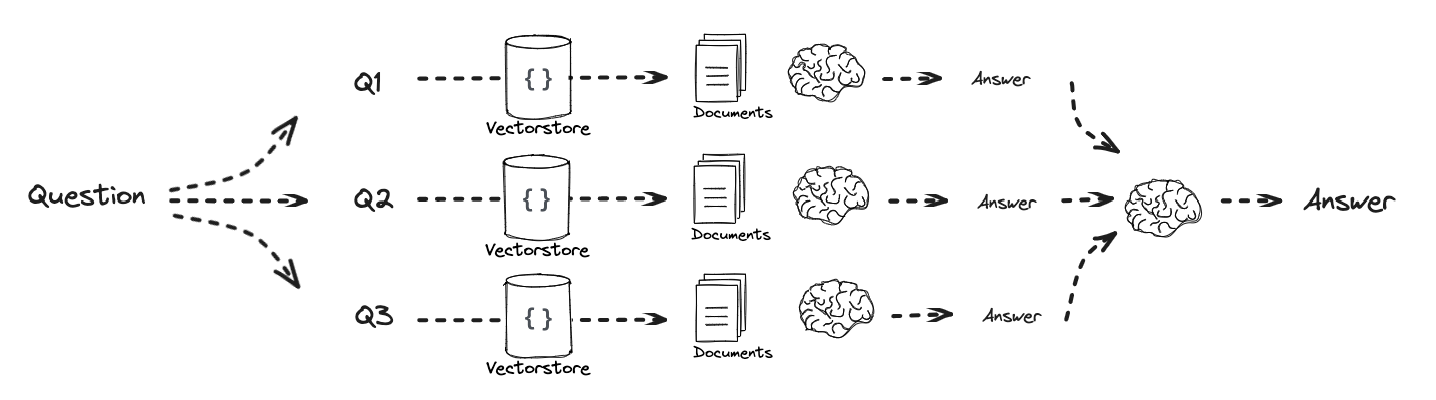

**How it works**:
1. Answer each sub-question independently using only retrieved documents
2. Each sub-question gets its own retrieval and answer generation
3. At the end, synthesize all the individual answers into a comprehensive response

**When to use independent answering**:
- When sub-questions are mostly independent of each other
- When you want to avoid bias from previous answers
- When you can process sub-questions in parallel for speed
- When you want each sub-question to get fresh retrieval

In [ ]:
# Use a standard RAG prompt from LangChain Hub for individual answering
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Load a standard RAG prompt - this is a well-tested prompt for question answering
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question, prompt_rag, sub_question_generator_chain):
    """
    Answer each sub-question independently using RAG.
    
    Process:
    1. Generate sub-questions using the decomposition chain
    2. For each sub-question:
       - Retrieve relevant documents independently
       - Generate an answer using only those documents (no previous context)
    3. Return all answers and sub-questions for synthesis
    """
    
    # Generate sub-questions from the complex question
    sub_questions = sub_question_generator_chain.invoke({"question": question})
    
    # Store results for each sub-question
    rag_results = []
    
    for i, sub_question in enumerate(sub_questions):
        print(f"Processing sub-question {i+1}: {sub_question[:100]}...")
        
        # Retrieve documents specifically for this sub-question
        # Each sub-question gets its own fresh retrieval
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Answer this sub-question using only its retrieved documents
        # No previous context or answers are used - completely independent
        answer = (prompt_rag | llm | StrOutputParser()).invoke({
            "context": retrieved_docs, 
            "question": sub_question
        })
        
        rag_results.append(answer)
        print(f"Answer generated for sub-question {i+1}")
    
    return rag_results, sub_questions

# Run independent answering on all sub-questions
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

print(f"\nCompleted independent answering for {len(questions)} sub-questions.")

In [ ]:
def format_qa_pairs(questions, answers):
    """Format multiple Q&A pairs for synthesis."""
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

# Format all the Q&A pairs for final synthesis
context = format_qa_pairs(questions, answers)

# Create a synthesis prompt that combines all individual answers
# This is where we bring together all the independent answers
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# Create the final synthesis chain
final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

# Generate the final synthesized answer
final_answer = final_rag_chain.invoke({"context": context, "question": question})

print("Final Synthesized Answer (Independent Approach):")
print(final_answer)

## Part 8: Step Back - From Specific to General

### The Problem with Overly Specific Questions

Sometimes users ask very specific questions, but the most relevant information in your knowledge base is at a higher level. For example:
- **Specific question**: "What is task decomposition for LLM agents?"
- **General concept**: The documents might discuss "planning strategies in AI systems" more broadly

### The Step Back Technique

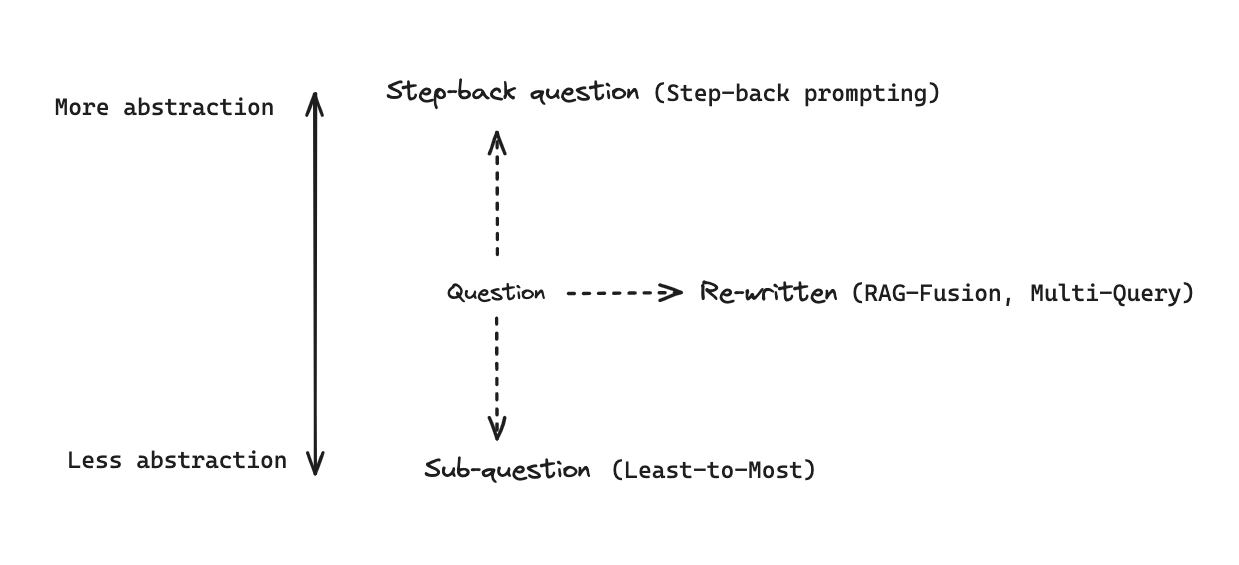

Step Back prompting solves this by generating a more abstract, general version of the specific question. Think of it as "zooming out" to see the bigger picture before diving into specifics.

**How it works**:
1. Take the original specific question
2. Generate a broader, more general "step-back" version
3. Retrieve documents using BOTH the original question AND the step-back question
4. Use both sets of documents to generate a comprehensive answer

### Why This Works

**Real-world analogy**: If you're looking for information about "iPhone 15 camera quality," you might also want to look at documents about "smartphone photography" in general. The general documents provide useful context and principles.

**Benefits**:
- **Broader context**: General questions retrieve foundational information
- **Better coverage**: Combines specific details with general principles
- **Handles specificity gaps**: When documents are more general than the question

### Reference Paper
- [Step-Back Prompting Paper](https://arxiv.org/pdf/2310.06117.pdf)

In [ ]:
# Create few-shot examples to teach the LLM how to generate step-back questions
# Few-shot learning gives the LLM concrete examples of the transformation we want
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples = [
    {
        # Example 1: From specific band question to general capability question
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        # Example 2: From specific person's birthplace to general personal history
        "input": "Jan Sindel's was born in what country?",
        "output": "what is Jan Sindel's personal history?",
    },
]

# Create a template for each example
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),  # The specific question
        ("ai", "{output}"),   # The step-back (general) question
    ]
)

# Create the few-shot prompt template
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

# Create the complete Step Back prompt
# This combines the system instruction, few-shot examples, and the new question
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Include the few-shot examples
        few_shot_prompt,
        # The new question to transform
        ("user", "{question}"),
    ]
)

print("Step Back prompt created with few-shot examples.")
print("This will teach the LLM to transform specific questions into general ones.")

In [ ]:
# Create the step-back question generator
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()

# Test with our specific question about LLM agents
question = "What is task decomposition for LLM agents?"
step_back_question = generate_queries_step_back.invoke({"question": question})

print(f"Original specific question: {question}")
print(f"Step-back general question: {step_back_question}")
print("\nNotice how the step-back question is broader and more general.")
print("This should help retrieve documents about general planning and AI concepts.")

In [ ]:
# Create the complete Step Back RAG system
# This retrieves documents using BOTH the original question AND the step-back question

response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""

response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

# Create the Step Back RAG chain
chain = (
    {
        # Retrieve documents using the original specific question
        # This gets documents that directly match the specific query
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        
        # Retrieve documents using the step-back general question
        # This gets documents about the broader topic area
        "step_back_context": generate_queries_step_back | retriever,
        
        # Pass through the original question for answer generation
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

# Generate answer using Step Back approach
step_back_answer = chain.invoke({"question": question})

print("Step Back RAG Answer:")
print(step_back_answer)
print("\n" + "="*50)
print("This answer combines:")
print("1. Specific information from the original question")
print("2. General background from the step-back question")
print("3. A more comprehensive understanding of the topic")

## Part 9: HyDE - Hypothetical Document Embeddings

### The Embedding Mismatch Problem

Here's a fascinating problem in RAG: sometimes your question and the relevant documents are very different in style and content, even though they're about the same topic.

**Example**:
- **Your question**: "What is task decomposition for LLM agents?"
- **Relevant document**: "Task decomposition is a fundamental planning technique in artificial intelligence systems. It involves breaking complex goals into smaller, manageable sub-tasks that can be executed sequentially or in parallel..."

The question is short and casual, while the document is formal and detailed. This mismatch can hurt embedding-based retrieval.

### HyDE: Generate First, Retrieve Second

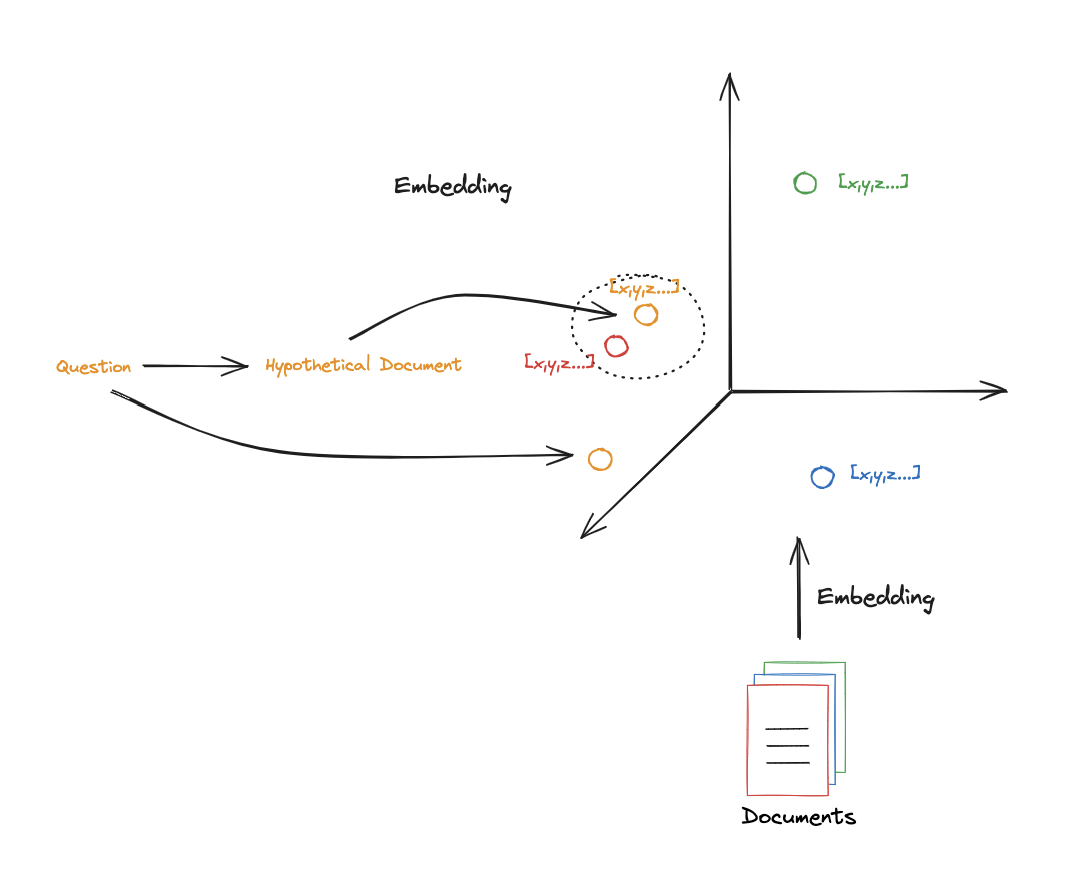

HyDE (Hypothetical Document Embeddings) solves this with a clever trick:

1. **Generate a hypothetical answer** to the user's question (even if it might be wrong)
2. **Use this hypothetical answer as the search query** instead of the original question
3. **Retrieve documents that are similar to the hypothetical answer**
4. **Generate the real answer** using the retrieved documents

### Why This Works

**The key insight**: A hypothetical answer will be much more similar in style and content to actual documents than a question is. Even if the hypothetical answer is partially wrong, it will still contain the right keywords, structure, and style to find relevant documents.

**Real-world analogy**: If you're looking for academic papers about machine learning, it's better to search using technical language ("supervised learning algorithms demonstrate superior performance...") rather than a casual question ("how does ML work?").

### References
- [LangChain HyDE Cookbook](https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb)
- [Original HyDE Paper](https://arxiv.org/abs/2212.10496)

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Create a prompt for generating hypothetical documents
# The key instruction: "write a scientific paper passage"
# This ensures the generated text matches the style of academic documents
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Create the hypothetical document generator
# This chain: question → hypothetical academic passage
generate_docs_for_retrieval = (
    prompt_hyde 
    | ChatOpenAI(temperature=0)  # Low temperature for consistent, focused generation
    | StrOutputParser() 
)

# Test HyDE with our question
question = "What is task decomposition for LLM agents?"
hypothetical_doc = generate_docs_for_retrieval.invoke({"question": question})

print("Original Question:")
print(question)
print("\n" + "="*50)
print("Hypothetical Document Generated:")
print(hypothetical_doc)
print("\n" + "="*50)
print("Notice how the hypothetical document:")
print("1. Uses academic/technical language")
print("2. Contains relevant keywords and concepts")
print("3. Matches the style of real documents in our knowledge base")
print("4. Will find better semantic matches during retrieval")

In [ ]:
# Use the hypothetical document for retrieval instead of the original question
# This is the core innovation of HyDE
retrieval_chain = generate_docs_for_retrieval | retriever 

# Retrieve documents using our hypothetical document as the query
retrieved_docs = retrieval_chain.invoke({"question": question})

print(f"HyDE retrieved {len(retrieved_docs)} documents")
print("\nFirst retrieved document preview:")
if retrieved_docs:
    print(retrieved_docs[0].page_content[:200] + "...")
    print("\nThis document was found because it's similar to our hypothetical document,")
    print("not because it's similar to the original question.")
else:
    print("No documents retrieved")

In [ ]:
# Generate the final answer using HyDE-retrieved documents
# Now we use the REAL documents to answer the original question
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# Create the final HyDE RAG chain
final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

# Generate the final answer
hyde_answer = final_rag_chain.invoke({"context": retrieved_docs, "question": question})

print("Final HyDE Answer:")
print(hyde_answer)
print("\n" + "="*50)
print("HyDE Process Summary:")
print("1. Generated hypothetical document from the question")
print("2. Retrieved real documents similar to the hypothetical one")
print("3. Used real documents to answer the original question")
print("4. Result: Better retrieval through style and content matching")

## Conclusion: Choosing the Right Query Transformation

Congratulations! You've learned five powerful query transformation techniques for RAG systems. Each has its own strengths and use cases:

### When to Use Each Technique

**Multi Query**: When you want to cast a wider net with multiple phrasings
- Best for: Simple questions that might be phrased many ways
- Example: "What is machine learning?" → Multiple variations

**RAG-Fusion**: When you want the benefits of Multi Query plus smart ranking
- Best for: When document quality and relevance ranking matters
- Example: Research questions where you need the most relevant sources

**Decomposition**: When dealing with complex, multi-part questions
- Best for: Complex questions that cover multiple topics
- Example: "What are the components and challenges of autonomous AI systems?"

**Step Back**: When questions are too specific for your document collection
- Best for: Highly specific questions where documents are more general
- Example: Specific product questions when you have general category information

**HyDE**: When there's a style mismatch between questions and documents
- Best for: Academic/technical documents with casual user questions
- Example: Technical documentation with everyday language queries

### Combining Techniques

These techniques can also be combined! For example:
- **Step Back + Multi Query**: Generate general questions, then create variations
- **Decomposition + RAG-Fusion**: Break down complex questions, then use fusion on sub-questions
- **HyDE + Multi Query**: Generate hypothetical documents, then create variations

### Key Takeaways

1. **One size doesn't fit all**: Different query transformations solve different problems
2. **Experiment with your data**: Test different approaches on your specific documents
3. **Consider your users**: Match the technique to how your users ask questions
4. **Monitor and iterate**: Use tools like LangSmith to see what works best
5. **Start simple, add complexity**: Begin with Multi Query, then try more advanced techniques

Remember: The goal of query transformations is to bridge the gap between how users ask questions and how information is stored in your documents. Choose the technique that best bridges that gap for your specific use case!

### Next Steps

- Try these techniques on your own documents
- Experiment with combining multiple approaches
- Use evaluation metrics to measure improvement
- Consider the computational cost vs. quality trade-offs for your application

**This concludes our comprehensive tutorial on RAG query transformations!**

**Feel free to experiment with these techniques on your own data and use cases.**